In [1]:
#######
#
#Program purpose:
# Plot spectrum of multi-color AGN disk as function of wavelength; allow for 'other than thin disk' regions
#  ---Plot up to 3 'altered' spectra and compare to unperturbed disk,
#  ---alter by artificially depressing flux interior to R_alt
#
#To use:
# User serviceable parts limited to:
#   --variables listed (and documented) between 'BEGIN PHYSICAL INPUTS' and 'END PHYSICAL INPUTS'
#   --variables preceded by 'USER' in the DISPLAY INPUTS section
#   --output file names (preceded by USER) near end of program
#
# To find planned future improvements, search '!!!'
#
# No warranty express or implied. Use at your own risk. Does not prevent drowning.
#
# Updates in v2_2:
#  --plot F_lambda, instead of lambda*F_lambda
#  --linearize x-axis (lambda)
#  --plot normalized, linearized flux on y-axis
#
# Updates in v2_3:
#  --plot two temp models on same plot, for comparison
#    -USER pick: tempmod=solid black, tempmod2=dashed black
#  --plot wavelength in nm
#  --added legend
#
# Updates in v2_4:
#  --read observed spectra from files and overplot!!!implementing
#
####
#
# Author: K. E. Saavik Ford

In [2]:
from pylab import *

import sys, os, time, string, math, subprocess
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## SI units
Msun=1.99e30 #kg per solar mass
Rsun=6.95e8 #meters per solar radius
G=6.67e-11
c=3e8
sigma_SB=5.7e-8 #stefan-boltzmann const
yr=3.15e7 #seconds per year
pc=3.086e16 #meters per parsec
AU=1.496e11 #meters per AU
h=6.626e-34 #planck const
kB=1.38e-23 #boltzmann const
m_p=1.67e-27 #mass of proton
sigma_T=6.65e-29 #Thomson xsec
PI=3.1415926
m_per_nm=1.0e-9

In [4]:
def find_B_lambda(Temp, lam):
    #Planck function
    #BB intensity=2hc^2/lam^5 * 1/(exp(hc/lamkT)-1)
    I=(2*h*c**2/pow(lam,5))/(exp(h*c/(lam*kB*Temp))-1)

    return I

In [6]:
def find_Temp(epsilon,M_SMBH,dotm_edd,radius,r_in,model):
    # Find temp as a fn of radius
    #
    # Options:
    #  Sirko & Goodman 2003 (SG): T_SG
    #  Zero torque at ISCO (ZT): T_ZT  *****DEFAULT
    #  Non-zero torque at ISCO (NZT): T_NZT
    #
    #  Sirko & Goodman 2003 is similar to non-zero torque at the ISCO
    #  ---but differs by factor to approximate spectral hardening
    # assume sigma_SB T^4=(3/8pi) dotM Omega^2
    # use Omega=sqrt(GM/r^3); put r in units r_g; dotM in units dotM_edd
    prefactor=pow(((3.0/2.0)*(c**5)*m_p/(epsilon*G*M_SMBH*Msun*sigma_T*sigma_SB)), 0.25)
    T_SG=prefactor*pow(dotm_edd, 0.25)*pow(radius,-0.75)
    
    # Non-zero-torque at ISCO temp profile:
    # include factor f, O(1), which approximates spectral hardening from pure BB
    # set f=2
    # prefactor is otherwise identical to SG
    # See e.g. Gammie 1999; Krolik & Agol 2000; Narayan et al. 1997; Ashfordi & Paczynski 2003
    f=2.0
    T_NZT=f*T_SG
    
    # Zero torque at the ISCO temp profile:
    # see e.g. Zimmerman et al. 2005
    # To implement:
    if (radius >= r_in):
        T_ZT = T_NZT*pow((1.0-pow(radius/r_in, -0.5)),0.25)
    else:
        T_ZT = 0.0

    if (model=='SG'):
        T = T_SG
    elif (model=='ZT'):
        T = T_ZT
    elif (model=='NZT'):
        T = T_NZT
    else:
        print('WARNING: temperature profile model not recognized, using zero-torque model')
        T=T_ZT
        
    return T

In [7]:
def find_area(r1,r2,r_g):
    #find area of annulus
    #2pi R deltaR
    area=2*PI*r1*r_g*(r2*r_g-r1*r_g)

    return area

In [19]:
def get_spectrum(path, filename):
    #assumes file contains ONLY wavelength and flux, in appropriate units, no headers, etc.
    
    #open the file for reading
    file1 = open(path+filename, 'r')

    #read in the data line by line, split into float lists of wavelength and flux
    lam1list=[]
    flux1list=[]
    for line in file1:
        line=line.strip()
        columns=line.split()
        lam1list.append(float(columns[0]))
        flux1list.append(float(columns[1]))

    #close file
    file1.close()

    #re-cast as arrays (from lists) for manipulation
    lam1 = np.array(lam1list)
    flux1 = np.array(flux1list)

    return lam1, flux1

In [20]:
    #get observed spectra and do stuff with it (optional)
    #USER: to skip plotting observed spectra, uncomment the specfilenames=[] line below
    #USER: path= specify relative path to ascii spectra files
    #USER: specfilenames= make comma-separated list of filenames for arbitrary number of normalized spectra
    #      keep inside square brackets
    #USER: speclamunits= factor to multiply speclam by to obtain units of nm (0.1 for Angstroms)
    #      specify for each file (can in principal be different), keep inside sqaure brackets
    #USER: specfluxunits= factor to multiply specflux by to obtain consistent units
    #      specify for each file, keep inside sqaure brackets
    path='/cos_pc19a_npr/programs/WISE/WISE_LCs/data/'
    specfilenames=['sdss_1.dat', 'sdss_2.dat', 'w1100m0052_b.flam.dat', 'w1100m0052_r.flam.dat']
    #specfilenames=[] ## USER: this one!
    speclamunits= [0.1, 0.1, 0.1, 0.1]
    specfluxunits=[1.0, 1.0, 3.8e17, 3.8e17]
    speccolors=['c','m','y','y']
    speclam=[]
    specflux=[]

    for i in range(len(specfilenames)):
        fn=specfilenames[i]
        obslam, obsflux=get_spectrum(path, fn)
        speclam.append(obslam)
        specflux.append(obsflux)


['sdss_1.dat', 'sdss_2.dat', 'w1100m0052_b.flam.dat', 'w1100m0052_r.flam.dat']
/cos_pc19a_npr/programs/WISE/WISE_LCs/data/
w1100m0052_r.flam.dat


/Users/npr1/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


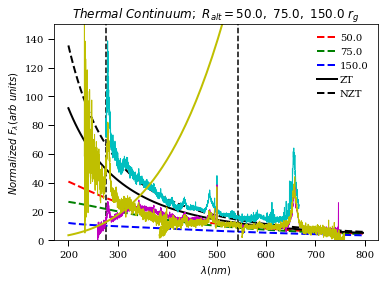

In [22]:
if __name__ == "__main__":
    #F_lam=sum over all blackbodies, assuming T(r), annuli of area=2piRdeltaR
    #integrating over solid angle=pi
    #BB intensity=2hc^2/lam^5 * 1/(exp(hc/lamkT)-1)
    #log_lam, lam=wavelength range of interest
    
    #BEGIN PHYSICAL INPUTS:
    M_SMBH=3.0e8              # mass of supermassive black hole in units of solar masses
    dotm_edd=0.01             # accretion rate in units of Eddington accretion 
    R_alt=[50.0, 75.0, 150.0] # R_alt=outermost radius of altered disk; units of r_g of SMBH

    # Choose unperturbed temperature profile model
    # see also 'find_Temp' for more details
    # options are:
    #   SG=Sirko & Goodman 2003
    #   ZT=zero-torque at ISCO model
    #   NZT=non-zero-torque at ISCO model
    #   If none of the above, default is ZT with warning
    tempmod='ZT'
    #plot 2nd temp mod
    tempmod2='NZT'

    # What fraction of flux, compared to unperturbed disk, is left in altered disk region?
    # !!!eventually would like to add more physical models!!!
    # f_depress=1.0 is unperturbed disk; f_depress=0.0 is no disk in altered region
    f_depress=0.10
    
    #USER can, but probably should not, alter the following physical
    #variables without thinking really hard:
    #
    #inner and outer disk radii in units of r_g of SMBH, unperturbed disk
    #(inner radius depends on spin, connect to epsilon later)!!!
    radius_in=6.0
    radius_out=1.0e4
    
    #epsilon=radiative efficiency, depends on spin of SMBH, assume 0.1
    epsilon=0.1
    #epsilon=1.0
    #END PHYSICAL INPUTS
    
    
    #BEGIN DISPLAY INPUTS:
    #divide display box for graphs
    #params for axes
    #format=left, bottom, width, height
    rect1=0.1,0.1,0.75,0.75
    
    #make figure
    fig1=plt.figure(1)
    #add axes & label them
    ax1=fig1.add_axes(rect1)
    ax1.set_ylabel(r"$Normalized \ F_{\lambda} (arb \ units)$")
    ax1.set_xlabel(r"$\lambda (nm)$")
    #Title is set for variable R_alt
    ax1.set_title(r"$Thermal \ Continuum; \ R_{alt}=%.1f, \ %.1f, \ %.1f \ r_{g}$" %(R_alt[0],R_alt[1],R_alt[2]))
    #choose colors for different R_alt
    R_color_cycle=['r','g','b']

    #set up range for x-axis
    #USER: choose min/max wavelength in nm
    lam_min=200.0
    lam_max=800.0
    #plt.xlim(600.0,750.0)
    #do arithmetic
    log_lam_min=log10(lam_min*1.0e-9)
    log_lam_max=log10(lam_max*1.0e-9)
    log_lam=np.arange(log_lam_min, log_lam_max, 0.01)
    lam=pow(10,log_lam)
    #USER: choose range for y-axis
    plt.ylim(0.0,150.0)
    #USER: set normalization factor for y-axis display
    normfactor=4.5e42
    #normfactor=3.4e42
    #USER: vertical lines for bandpass (optional)
    #USER: choose 'y' to plot, set source redshift, min/max bandpass wavelength in nm
    plot_bandpass='y'
    redshift=0.378
    band_min=380.0
    band_max=750.0
    
    #END DISPLAY INPUTS
    
    #compute r_g for SMBH:
    r_g_SMBH=G*M_SMBH*Msun/c**2
    
    # set up y-axis variables
    # divvy up disk radii
    log_radius=np.arange(log10(radius_in),log10(radius_out),0.01)
    radius=pow(10,log_radius)
    
    #make an iterable for multiple R_alt & loop
    flux_iter_R=[]
    for j in range(len(R_alt)):
        #initialize final spectrum arrays
        F_lam_tot=np.zeros(len(lam))
        F_lam_resid=np.zeros(len(lam))
        #setup model for comparison
        F_lam_compare=np.zeros(len(lam))
        #compute temp, area, emitted spectrum at each radius; then sum
        for i in range((len(radius)-1)):
            #std
            Temp=find_Temp(epsilon,M_SMBH,dotm_edd,radius[i],radius_in,tempmod)
            #comparison
            Temp_compare=find_Temp(epsilon,M_SMBH,dotm_edd,radius[i],radius_in,tempmod2)
            #std
            B_lambda=find_B_lambda(Temp, lam)
            #comparison
            B_lambda_compare=find_B_lambda(Temp_compare, lam)
            Area=find_area(radius[i],radius[i+1],r_g_SMBH)
            #flux is pi*A*B_lambda per annulus, pi from integrating over solid angle
            #std
            F_lam_ann         = PI*Area*B_lambda
            #comparison
            F_lam_ann_compare = PI*Area*B_lambda_compare
            if (radius[i] >= R_alt[j]):
                #only add to total if outside R_alt
                #std
                F_lam_tot=F_lam_tot+F_lam_ann
                #compare
                F_lam_compare=F_lam_compare+F_lam_ann_compare
            else:
                #if interior to gap, cut flux
                F_lam_tot=F_lam_tot+f_depress*F_lam_ann
                #add missing frac to resid to recover unperturbed spec
                F_lam_resid=F_lam_resid+(1-f_depress)*F_lam_ann
                #compare--just add it in for now
                F_lam_compare=F_lam_compare+F_lam_ann_compare
        #take log of total spectrum for plotting, dump to iterables for plotting
        log_F_lam=log10(F_lam_tot)
        #log_lam_F_lam=log10(F_lam_tot*lam)
        F_lam_all=F_lam_tot+F_lam_resid
        #log_lam_F_lam_all=log10(F_lam_all*lam)
        log_F_lam_all=log10(F_lam_all)
        #flux_iter_R.append(log_F_lam)
        flux_iter_R.append(F_lam_tot)

    for j in range(len(R_alt)):
        #plot altered spectra (tempmod)
        ax1.plot(lam/m_per_nm, flux_iter_R[j]/normfactor, color=R_color_cycle[j], 
                 ls='dashed', linewidth=2, label=str(R_alt[j]))
    #plot unaltered spectrum (tempmod)
    ax1.plot(lam/m_per_nm, F_lam_all/normfactor, 
             color='black', ls='solid', linewidth=2, label=tempmod)
    #plot unaltered comparison temp model (tempmod2)
    ax1.plot(lam/m_per_nm, F_lam_compare/normfactor, 
             color='black', ls='dashed', linewidth=2, label=tempmod2)

    #legend
    ax1.legend(loc='upper right')
    
    #plot bandpass lines, if selected
    if (plot_bandpass=='y'):
        #band_min_line=log10(band_min*1.0e-9/(1.0+redshift))
        #band_max_line=log10(band_max*1.0e-9/(1.0+redshift))
        band_min_line=(band_min/(1.0+redshift))
        band_max_line=(band_max/(1.0+redshift))
        plt.axvline(x=band_min_line, color='k', linestyle='--')
        plt.axvline(x=band_max_line, color='k', linestyle='--')
    #plot observed spectra
    for i in range(len(specfilenames)):
        ax1.plot(speclam[i]*speclamunits[i]/(1.0+redshift), specflux[i]*specfluxunits[i], color=speccolors[i], ls='solid', linewidth=1)

    #!!!experiment
    rayscat=23.0*pow(((lam/m_per_nm)/320.0),4.0)
    ax1.plot(lam/m_per_nm,rayscat, color='y', ls='solid', linewidth=2)


    #output to files in appropriate formats
    #USER: choose your filenames/formats
    savefig('mcd_gap_v2_4_temp.eps')
    savefig('mcd_gap_v2_4_temp.png')
    show()
